<a href="https://colab.research.google.com/github/axelpuyo/liasd/blob/master/perceptive_bias_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installs requirements and mounts file to Google Drive in order to save models.

In [ ]:
## Run once
!pip -q install import-ipynb

from google.colab import drive
drive.mount('/content/drive')

# check path
import os
print(os.getcwd())
print(os.listdir())

# cd your_path
%cd drive/MyDrive/Colab Notebooks/liasd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content
['.config', 'drive', 'sample_data']
/content/drive/MyDrive/Colab Notebooks/liasd


Necessary imports, please note that when any imported .ipynb files are modified, you need to restart runtime (CTRL + M or Runtime > Restart Runtime) in order for changes to take effect.

In [ ]:
import import_ipynb
import utils
import colored_mnist
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt

tf1 = False

importing Jupyter notebook from utils.ipynb
importing Jupyter notebook from colored_mnist.ipynb


SHAP's `DeepExplainer` does not support TensorFlow 2.0+ (namely eager-mode by default), while `Grad-CAM` requires it. Thus, we train the same model on two different versions of TensorFlow (1.x and 2.x behavior). However, the behavior of TensorFlow can only be changed at the beginning of a runtime. **In order to switch versions, you need to restart runtime**. 



In [ ]:
## TensorFlow version swapping (SHAP works with TF 1.x, GRAD-CAM with TF 2.x) 
# Uncomment this for TensorFlow 1.x behavior (not running eagerly by default, which is a requirement for SHAP.)
tf.compat.v1.disable_v2_behavior()
tf.compat.v1.disable_eager_execution()
tf1 = True

print('TensorFlow 2.x behavior ? ', tf.executing_eagerly())

Instructions for updating:
non-resource variables are not supported in the long term
TensorFlow 2.x behavior ?  False


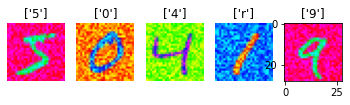

In [ ]:
(train_images, train_colors, train_numbers, train_mixed), (test_images, test_colors, test_numbers, test_mixed) = colored_mnist.load_data(8000)

for i in range(5):
  plt.axis('off')
  plt.subplot(1, 5, i+1)
  plt.title(utils.uncategoric(train_mixed[i])[0])
  plt.imshow(train_images[i])

In [ ]:
# Color-biased model
color_model = keras.Sequential()
color_model.add(keras.layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='relu', input_shape=train_images[0].shape))
color_model.add(keras.layers.MaxPool2D(pool_size=(2,2)))
color_model.add(keras.layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
color_model.add(keras.layers.MaxPool2D(pool_size=(2,2), padding='same'))
color_model.add(keras.layers.Flatten())
color_model.add(keras.layers.Dense(3))
color_model.add(keras.layers.Softmax())

input_shape = train_images.shape
color_model.build(input_shape)

color_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
# color_model.summary()

print('>> Color-biased model training')
color_model.fit(train_images, train_colors, batch_size=12, epochs=5, shuffle=True)

>> Color-biased model training
Train on 8000 samples
Epoch 1/5
8000/8000 [==============================] - 6s 783us/sample - loss: 0.0109 - acc: 0.9969
Epoch 2/5
8000/8000 [==============================] - 3s 387us/sample - loss: 1.1925e-07 - acc: 1.0000
Epoch 3/5
8000/8000 [==============================] - 5s 568us/sample - loss: 1.1921e-07 - acc: 1.0000
Epoch 4/5
8000/8000 [==============================] - 4s 560us/sample - loss: 1.1921e-07 - acc: 1.0000
Epoch 5/5
8000/8000 [==============================] - 4s 519us/sample - loss: 1.1921e-07 - acc: 1.0000


In [ ]:
# Shape-biased model
shape_model = keras.Sequential()
shape_model.add(keras.layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='relu', input_shape=train_images[0].shape))
shape_model.add(keras.layers.MaxPool2D(pool_size=(2,2)))
shape_model.add(keras.layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
shape_model.add(keras.layers.MaxPool2D(pool_size=(2,2), padding='same'))
shape_model.add(keras.layers.Flatten())
shape_model.add(keras.layers.Dense(10))
shape_model.add(keras.layers.Softmax())

input_shape = train_images.shape
shape_model.build(input_shape)

shape_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
# shape_model.summary()

print('>> Shape-biased model training')
shape_model.fit(train_images, train_numbers, batch_size=12, epochs=15, shuffle=True)

>> Shape-biased model training
Train on 8000 samples
Epoch 1/25
8000/8000 [==============================] - 5s 587us/sample - loss: 0.7775 - acc: 0.7511
Epoch 2/25
8000/8000 [==============================] - 5s 584us/sample - loss: 0.1659 - acc: 0.9514
Epoch 3/25
8000/8000 [==============================] - 4s 532us/sample - loss: 0.1151 - acc: 0.9656
Epoch 4/25
8000/8000 [==============================] - 3s 367us/sample - loss: 0.0900 - acc: 0.9720
Epoch 5/25
8000/8000 [==============================] - 3s 351us/sample - loss: 0.0705 - acc: 0.9809
Epoch 6/25
8000/8000 [==============================] - 3s 366us/sample - loss: 0.0545 - acc: 0.9854
Epoch 7/25
8000/8000 [==============================] - 3s 361us/sample - loss: 0.0494 - acc: 0.9866
Epoch 8/25
8000/8000 [==============================] - 3s 366us/sample - loss: 0.0373 - acc: 0.9890
Epoch 9/25
8000/8000 [==============================] - 3s 422us/sample - loss: 0.0294 - acc: 0.9927
Epoch 10/25
8000/8000 [===============

In [ ]:
# Rule-biased model
model = keras.Sequential()
model.add(keras.layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='relu', input_shape=train_images[0].shape, name='conv1'))
model.add(keras.layers.MaxPool2D(pool_size=(2,2)))
model.add(keras.layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(keras.layers.MaxPool2D(pool_size=(2,2), padding='same'))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(13))
model.add(keras.layers.Softmax())

input_shape = train_images.shape
model.build(input_shape)

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()

print('>> Rule-biased model training')
model.fit(train_images, train_mixed, batch_size=12, epochs=25, shuffle=True)

>> Rule-biased model training
Train on 8000 samples
Epoch 1/25
8000/8000 [==============================] - 3s 384us/sample - loss: 0.5074 - acc: 0.8395
Epoch 2/25
8000/8000 [==============================] - 4s 460us/sample - loss: 0.1300 - acc: 0.9628
Epoch 3/25
8000/8000 [==============================] - 4s 478us/sample - loss: 0.0887 - acc: 0.9756
Epoch 4/25
8000/8000 [==============================] - 3s 364us/sample - loss: 0.0677 - acc: 0.9825
Epoch 5/25
8000/8000 [==============================] - 3s 371us/sample - loss: 0.0482 - acc: 0.9866
Epoch 6/25
8000/8000 [==============================] - 3s 366us/sample - loss: 0.0396 - acc: 0.9895
Epoch 7/25
8000/8000 [==============================] - 3s 364us/sample - loss: 0.0299 - acc: 0.9918
Epoch 8/25
8000/8000 [==============================] - 3s 364us/sample - loss: 0.0250 - acc: 0.9937
Epoch 9/25
8000/8000 [==============================] - 3s 362us/sample - loss: 0.0162 - acc: 0.9946
Epoch 10/25
8000/8000 [================

Saves models in tf1 or tf2 directories depending on the TensorFlow version that was used.

In [ ]:
## save models
if tf1:
  color_model.save('saved_models/tf1/color_biased_tf1')
  shape_model.save('saved_models/tf1/shape_biased_tf1')
  model.save('saved_models/tf1/rule_biased_tf1')
  print('saved in tf1')
else:
  color_model.save('saved_models/tf2/color_biased_tf2')
  shape_model.save('saved_models/tf2/shape_biased_tf2')
  model.save('saved_models/tf2/rule_biased_tf2')
  print('saved in tf2')

saved in tf1
